In [1]:
# import statements
from Tools.toolbox import *
from Tools.functions import *
import csv
from scipy.stats import ks_2samp
import pandas as pd

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
dates_ebola = []
countries_ebola = []
with open('data/ebola_sorted.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        countries_ebola.append(row[0])
        dates_ebola.append(row[4])

data = {
    'Country': countries_ebola,
    'Date Onset Inferred': dates_ebola
}

df = pd.DataFrame(data)
df = df[df['Date Onset Inferred'] != 'NA']
countries = df.groupby('Country')
df_guinea = countries.get_group('Guinea')
dates_guinea = [date for date in df_guinea['Date Onset Inferred']]
df_liberia = countries.get_group('Liberia')
dates_liberia = [date for date in df_liberia['Date Onset Inferred']]
df_sierra = countries.get_group('Sierra Leone')
dates_sierra = [date for date in df_sierra['Date Onset Inferred']]
def sort_dates(dates):
    def date_key(date_string):
        return datetime.strptime(date_string, '%d/%m/%Y')
    return sorted(dates, key=date_key)
dates_all = sort_dates(df['Date Onset Inferred'])

In [3]:
date_nums_guinea = [convert_date_to_numberB(date, dates_guinea[0]) for date in dates_guinea]
date_nums_liberia = [convert_date_to_numberB(date, dates_liberia[0]) for date in dates_liberia]
date_nums_sierra = [convert_date_to_numberB(date, dates_sierra[0]) for date in dates_sierra]
date_nums_all = [convert_date_to_numberB(date, dates_all[0]) for date in dates_all]

In [4]:
observed_guinea = distribute(date_nums_guinea)
observed_liberia = distribute(date_nums_liberia)
observed_sierra = distribute(date_nums_sierra)
observed_all = distribute(date_nums_all)

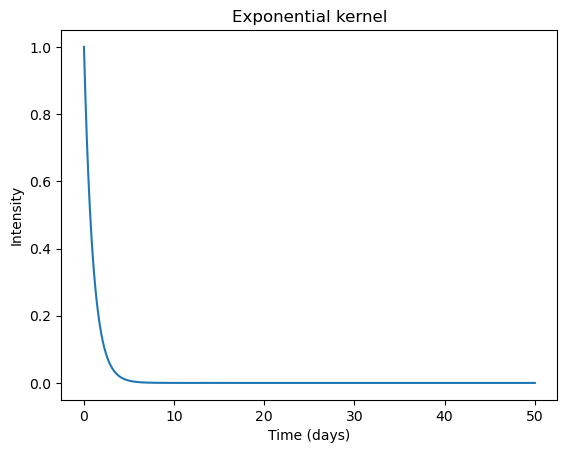

In [5]:
time50 = np.linspace(0,50,10000)
kernel_intensity = [ExpKernel(1, 1)(t) for t in time50]
plt.plot(time50, kernel_intensity)
plt.xlabel("Time (days)")
plt.ylabel("Intensity")
plt.title("Exponential kernel")
plt.show()

In [6]:
event_times = observed_sierra
paras = [0.5, 0.5, 3]
bnds = ((0.01, 1), (0.01, 1), (0.01, 10))
intensity = lambda t, paras: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=7)
result = MLE_de(intensity, event_times, model="constexp", bounds=bnds, maxiter=100)
optimized_params = result.x
print(optimized_params)

KeyboardInterrupt: 

In [ ]:
paras = [0.72320704, 0.72559652, 0.11672481]
intensity = lambda t, event_times: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=7)
samples2 = []
for _ in range(10):
    samples2.append(simulate_cluster_structure(ExpKernel(*paras[:2]), ConstBase(paras[-1]), 600))

In [ ]:
for sample in samples2:
    plt.plot(sample, range(len(sample)), color="k", alpha=0.15)
plt.plot(event_times, range(len(event_times)), color='r')
plt.show()

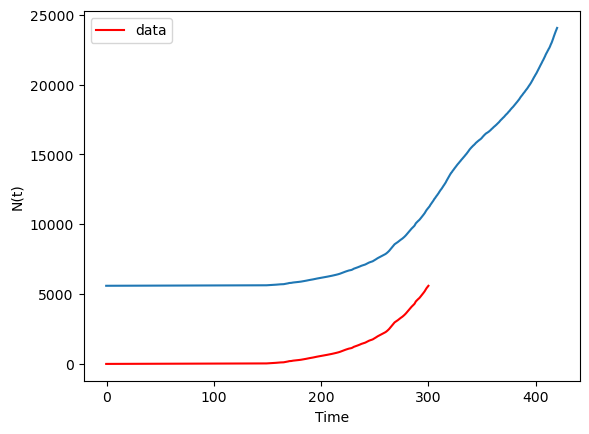

In [7]:
paras = [0.72320704, 0.72559652, 0.11672481]
n = binary_search(event_times, 300)
intensity = lambda t, event_times: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=10)
prediction(intensity, event_times[:n], 300, p=0.4, n=1)

In [ ]:
for sample in samples2:
    plt.plot(sample, range(len(sample)), color="k", alpha=1)
plt.plot(event_times, range(len(event_times)), color='r')
plt.show()

In [ ]:
paras = [0.5, 0.5, 1, 300000]
n = binary_search(event_times, 600)
intensity_SIR = lambda t, event_times: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, SIR=True, depth=100)

samples = []
for _ in range(1):
    samples.append(simulate_hawkes_process(intensity_SIR, [], 300))

In [ ]:
for sample in samples:
    plt.plot(sample, range(len(sample)), color="k", alpha=0.15)
plt.plot(event_times, range(len(event_times)), color='r')
plt.show()

In [ ]:
def grad_hess(paras):
    a, d, c = paras
    t = event_times.copy()
    n = len(t)
    
    def ABC(i):
        A_val = 0
        B_val = 0
        C_val = 0
        for j in range(i - 1, -1, -1):
            if t[i] - t[j] >= 100:
                return A_val, B_val, C_val
            else:
                tij = (t[i]-t[j])
                exptij = np.exp(-d*tij)
                A_val += exptij
                B_val += tij * exptij
                C_val += tij**2 * exptij
        return A_val, B_val, C_val
    
    pda_val = 0
    pdd_val = 0
    pdc_val = -t[-1]
    
    pdaa_val = 0
    pdad_val = 0
    pddd_val = 0
    pdac_val = 0
    pddc_val = 0
    pdcc_val = 0
        
    for i in range(n - 1, -1, -1):
        if t[-1] - t[i] >= 100:
            return (np.array([pda_val, pdd_val, pdc_val]), np.array([[pdaa_val, pdad_val, pdac_val],
                                                            [pdad_val, pddd_val, pddc_val],
                                                            [pdac_val, pddc_val, pdcc_val]]))
        else:
            Ai, Bi, Ci = ABC(i)
            tni = t[-1] - t[i]
            exptni = np.exp(-d * tni)
            denom = 1 / (c + a * Ai)
            d2 = d**2
            
            pda_val += (exptni / d + Ai * denom)
            pdd_val += ((-a) * tni * exptni * (1 + d) / d2 - a * Bi * denom)
            pdc_val += denom
            
            pdaa_val -= (Ai * denom)**2
            pdad_val -= (tni * exptni / d + (exptni - 1) / d2)
            pdac_val -= Ai * denom**2
            pddd_val += (a * tni ** 2 * exptni / d + 2 * tni * exptni / d2 + 2 * (exptni - 1) * d**(-3) + Ci * denom - a * Bi**2 / d2) 
            pddc_val += a * Bi * denom**2
            pdcc_val -= denom**2
        
    return (np.array([pda_val, pdd_val, pdc_val]), np.array([[pdaa_val, pdad_val, pdac_val],
                                                            [pdad_val, pddd_val, pddc_val],
                                                            [pdac_val, pddc_val, pdcc_val]]))
def grad(paras):
    return grad_hess(paras)[0]

def hess(paras):
    return grad_hess(paras)[1]

In [ ]:
def grad_hessC(paras):
    a, c = paras
    t = event_times.copy()
    n = len(t)
    
    def ABC(i):
        A_val = 0
        B_val = 0
        C_val = 0
        for j in range(i - 1, -1, -1):
            if t[i] - t[j] >= 300:
                return A_val, B_val, C_val
            else:
                tij = (t[i]-t[j])
                exptij = np.exp(-a*tij)
                A_val += exptij
                B_val += tij * exptij
                C_val += tij**2 * exptij
        return A_val, B_val, C_val
    
    pda_val = 0
    pdc_val = -t[-1]
    
    pddd_val = 0
    pddc_val = 0
    pdcc_val = 0
        
    for i in range(n - 1, -1, -1):
        if t[-1] - t[i] >= 300:
            return (np.array([pda_val, pdc_val]), np.array([[pddd_val, pddc_val],
                                                            [pddc_val, pdcc_val]]))
        else:
            Ai, Bi, Ci = ABC(i)
            tni = t[-1] - t[i]
            exptni = np.exp(-a * tni)
            denom = 1 / (c + a * Ai)
            
            pda_val += (-tni * exptni + (Ai - a * Bi) * denom)
            pdc_val += denom
            
            pddd_val += (tni ** 2 * exptni + (-2 * c * Bi + c * a * Ci - Ai**2 + 2 * a * Ai * Bi - a**2 * Bi**2) * denom**2) 
            pddc_val += ((a * Bi - Ai) * denom**2)
            pdcc_val -= denom**2
        
    return (np.array([pda_val, pdc_val]), np.array([[pddd_val, pddc_val],
                                                    [pddc_val, pdcc_val]]))
def gradC(paras):
    return grad_hessC(paras)[0]

def hessC(paras):
    return grad_hessC(paras)[1]

In [ ]:
def gradC(paras):
    a, c = paras
    t = event_times.copy()
    n = len(t)
    
    def AB(i):
        A_val = 0
        B_val = 0
        for j in range(i - 1, -1, -1):
            if t[i] - t[j] >= 600:
                return A_val, B_val
            else:
                tij = (t[i]-t[j])
                exptij = np.exp(-a*tij)
                A_val += exptij
                B_val += tij * exptij
        return A_val, B_val
    
    pda_val = 0
    pdc_val = -t[-1]
        
    for i in range(n - 1, -1, -1):
        if t[-1] - t[i] >= 600:
            return np.array([pda_val, pdc_val])
        else:
            Ai, Bi= AB(i)
            tni = t[-1] - t[i]
            exptni = np.exp(-a * tni)
            denom = 1 / (c + a * Ai)
            
            pda_val += (-tni * exptni + (Ai - a * Bi) * denom)
            pdc_val += denom
        
    return np.array([pda_val, pdc_val])

In [ ]:
print(gradC([0.7, 0.2]))

In [ ]:
print(grad_hessC([0.7, 0.2]))